# Overview:
Imported data from the previous step and conducted analysis to make forest plot.


# Steps:
1. Import data
2. Conduct analysis
    * using the `metafor` package
    * using the `rma` random effects model function
    * got summary statistics
      * Heterogeneity
      * Overall effect size
      * Confidence interval
      * P-value
3. Make forest plot
4. Calculate the pooled odds ratio

In [22]:
# read in the processed data from the previous notebook
data <- read.csv("processed-data.csv")

# show the first few rows of the data
head(data)

,X.1,Article_ID,Total_Cohort,Measure_Name,Measure_Value,X95_CI_lower,X95_CI_upper,N1_Cancer,N2_No_Cancer,Cancer.Type,...,n,OR,odds_ratio,lower_ci,upper_ci,article_id,cancer_type,cancer_group,exclude_from_overall_plot,Article_Code
,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<int>,<int>,<chr>,...,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,"Di Luccia, 2010","1,216",OR,3.04,1.22,7.57,0,0,Melanoma,...,1216,3.0400,3.0400,1.22,7.57,"Di Luccia, 2010",Melanoma,SKIN,,D10
2,2,"Brewster, 2010","77,518",SIR,1.40,0.17,5.04,0,0,Melanoma,...,77518,1.4000,1.4000,0.17,5.04,"Brewster, 2010",Melanoma,SKIN,,B10
3,3,"Brewster, 2010","77,518",SIR,0.00,0.00,3.11,0,0,Basal Cell Carcinoma,...,77518,0.0001,0.0001,0.00,3.11,"Brewster, 2010",Basal Cell Carcinoma,SKIN,,B10
4,4,"Cnattingius, 1995",89,OR,7.50,1.80,31.90,0,0,Myeloid Leukemia,...,89,7.5000,7.5000,1.80,31.90,"Cnattingius, 1995",Myeloid Leukemia,BLOOD,,C95
5,5,"Bugaiaki-Shaked, 2022","342,172",HR,1.33,0.95,1.84,0,0,Total Malignant Morbidity,...,342172,1.3300,1.3300,0.95,1.84,"Bugaiaki-Shaked, 2022",Total Malignant Morbidity,SOLID ORGAN,,B22
6,6,"Bugaiaki-Shaked, 2022","342,172",HR,1.09,0.92,1.30,0,0,Total Bengin Tumors,...,342172,1.0900,1.0900,0.92,1.30,"Bugaiaki-Shaked, 2022",Total Bengin Tumors,SOLID ORGAN,,B22


Number of rows: 41 
The overall effect size (odds ratio) is 0.8592167 with 95% confidence interval ( 0.6700385 ,  1.101807 )
Pooled odds ratio: 1.513581 
95% CI: 1.393357 - 1.644179 

Random-Effects Model (k = 41; tau^2 estimator: DL)

   logLik   deviance        AIC        BIC       AICc   
-158.0827   315.8577   320.1655   323.5926   320.4812   

tau^2 (estimated amount of total heterogeneity): 0.4146 (SE = 0.2778)
tau (square root of estimated tau^2 value):      0.6439
I^2 (total heterogeneity / total variability):   94.14%
H^2 (total variability / sampling variability):  17.07

Test for Heterogeneity:
Q(df = 40) = 682.7977, p-val < .0001

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub    
 -0.1517  0.1269  -1.1959  0.2317  -0.4004  0.0969    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



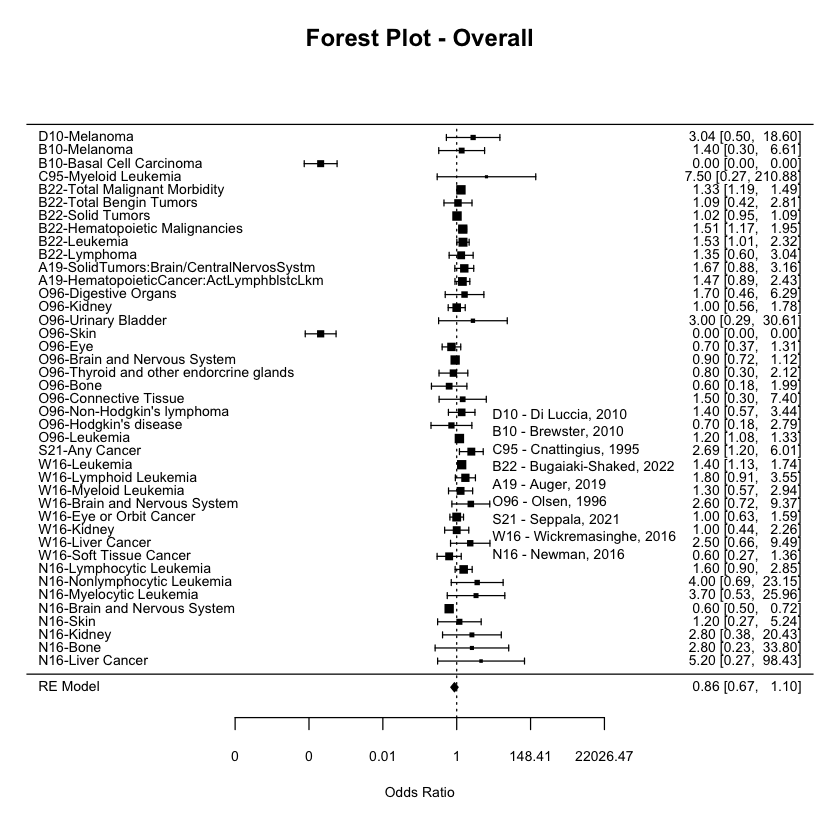

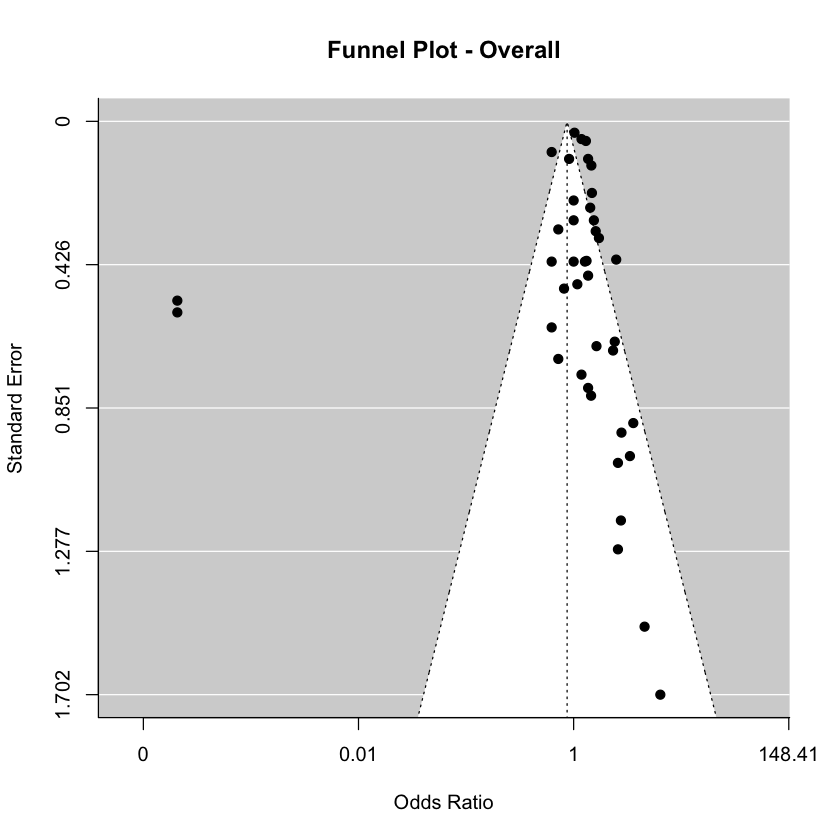

In [23]:
library(metafor)

# make the forest plot into a function that takes a data frame as input
draw_forest_and_funnel_plots <- function(dataset, groupName) {
    cat("Number of rows:", nrow(dataset), "\n")
    # create a meta-analysis object
    result <- rma(yi = log(dataset$odds_ratio), 
                    sei = log(dataset$upper_ci - dataset$lower_ci)/2, 
                    method = "DL")

    # Summarize the results
    cat("The overall effect size (odds ratio) is", 
        exp(result$b), "with 95% confidence interval (", 
        exp(result$b - 1.96 * result$se), ", ",
        exp(result$b + 1.96 * result$se), ")\n")

    # Calculate the log odds ratios and their standard errors
    log_or <- log(dataset$odds_ratio)
    se_log_or <- (log(dataset$upper_ci) - log(dataset$lower_ci)) / (2 * qnorm(0.975))

    # Calculate the weights for each study
    weights <- 1 / se_log_or^2

    # Calculate the pooled log odds ratio and its standard error
    pooled_log_or <- sum(weights * log_or) / sum(weights)
    pooled_se_log_or <- sqrt(1 / sum(weights))

    # Calculate the pooled odds ratio and its confidence interval
    pooled_or <- exp(pooled_log_or)
    lower_ci <- exp(pooled_log_or - 1.96 * pooled_se_log_or)
    upper_ci <- exp(pooled_log_or + 1.96 * pooled_se_log_or)

    # Print the results
    cat("Pooled odds ratio:", pooled_or, "\n")
    cat("95% CI:", lower_ci, "-", upper_ci, "\n")
    
    # pretty summary of the results
    print(summary(result))

    # Plot the forest plot
    forest(
        result, 
        atransf=exp, 
        xlab="Odds Ratio", 
        slab=abbreviate(paste(dataset$Article_Code, dataset$cancer_type, sep="-"), minlength = 40),
        main=paste("Forest Plot -", groupName),
        cex=0.7,
        )

    # legend to show the article IDs
    legend("topright", 
           legend=paste(unique(dataset$Article_Code),unique(dataset$article_id), sep = " - "),
           cex=0.7,
           bty="n",
           text.width=1,
           inset=c(0.38,0.5)
           )

    # Plot the funnel plot
    funnel(result, atransf=exp, xlab="Odds Ratio", ylab="Standard Error", main=paste("Funnel Plot -", groupName))

    
}

# exclude studies that have exclude_from_overall_plot set to YES
overall_plot_data <- data[data$exclude_from_overall_plot != "YES",] 

draw_forest_and_funnel_plots(overall_plot_data, 'Overall')

Cancer Group: SKIN 
----------------------------------------------------------------
Number of rows: 6 
The overall effect size (odds ratio) is 0.06332175 with 95% confidence interval ( 0.000844225 ,  4.749497 )
Pooled odds ratio: 2.123959 
95% CI: 1.081292 - 4.17205 

Random-Effects Model (k = 6; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-17.8079   28.5882   39.6157   39.1993   43.6157   

tau^2 (estimated amount of total heterogeneity): 28.5638 (SE = 19.5295)
tau (square root of estimated tau^2 value):      5.3445
I^2 (total heterogeneity / total variability):   98.31%
H^2 (total variability / sampling variability):  59.26

Test for Heterogeneity:
Q(df = 5) = 296.3246, p-val < .0001

Model Results:

estimate      se     zval    pval    ci.lb   ci.ub    
 -2.7595  2.2028  -1.2527  0.2103  -7.0770  1.5580    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



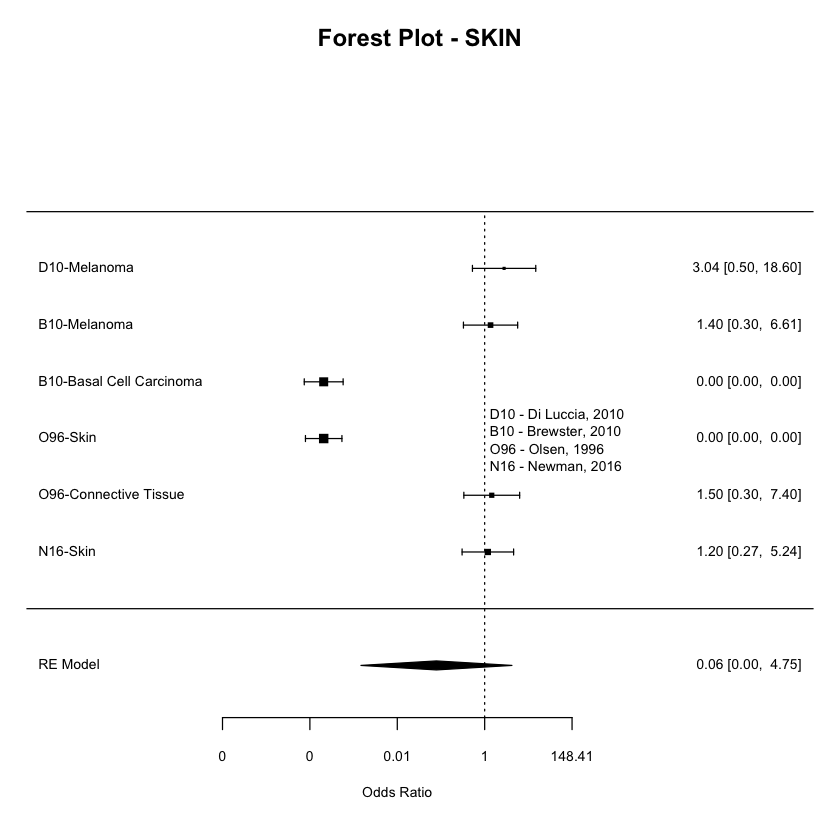

----------------------------------------------------------------
Cancer Group: BLOOD 
----------------------------------------------------------------
Number of rows: 11 
The overall effect size (odds ratio) is 1.298762 with 95% confidence interval ( 1.195911 ,  1.410459 )
Pooled odds ratio: 1.563395 
95% CI: 1.34927 - 1.811499 

Random-Effects Model (k = 11; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
 -2.2827    9.9911    8.5654    9.3612   10.0654   

tau^2 (estimated amount of total heterogeneity): 0 (SE = 0.0142)
tau (square root of estimated tau^2 value):      0
I^2 (total heterogeneity / total variability):   0.00%
H^2 (total variability / sampling variability):  1.00

Test for Heterogeneity:
Q(df = 10) = 9.9911, p-val = 0.4413

Model Results:

estimate      se    zval    pval   ci.lb   ci.ub      
  0.2614  0.0421  6.2102  <.0001  0.1789  0.3439  *** 

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



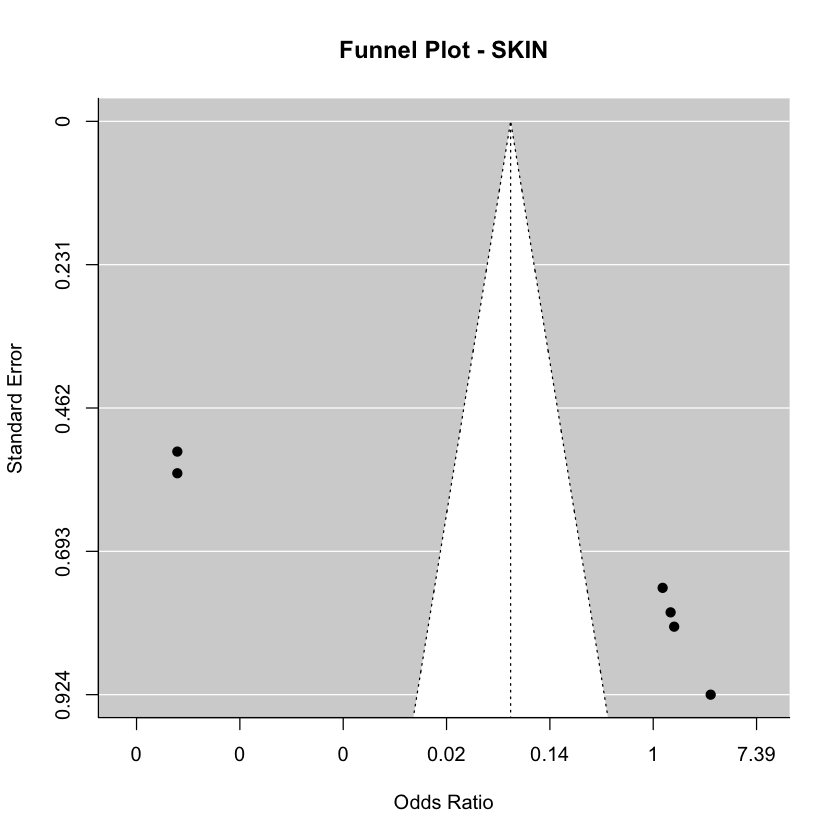

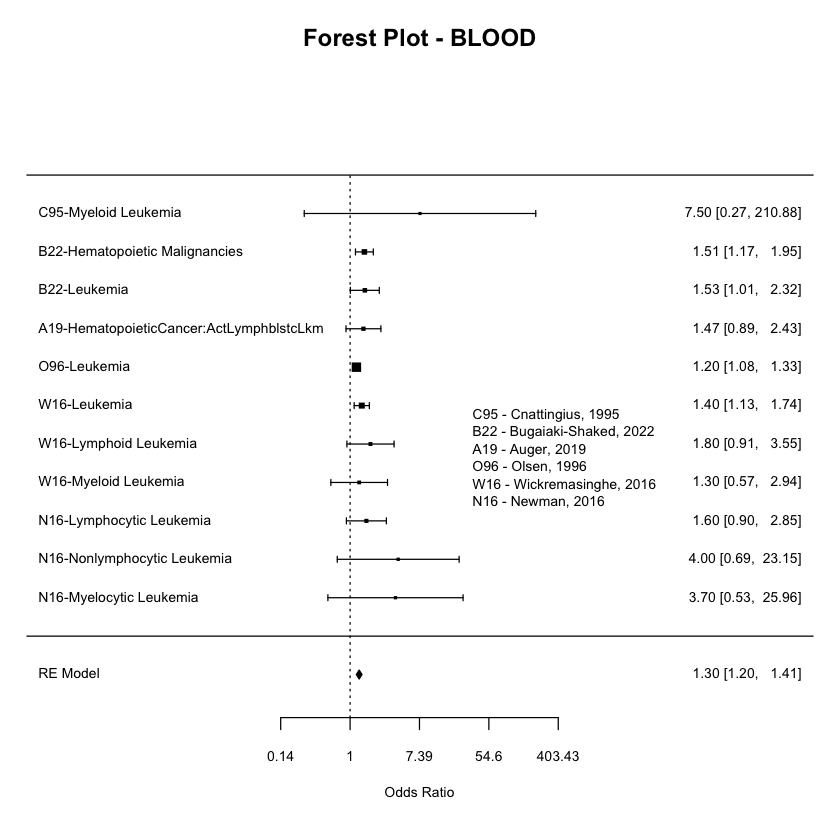

----------------------------------------------------------------
Cancer Group: SOLID ORGAN 
----------------------------------------------------------------
Number of rows: 23 
The overall effect size (odds ratio) is 1.020046 with 95% confidence interval ( 0.8578092 ,  1.212966 )
Pooled odds ratio: 1.194885 
95% CI: 1.062044 - 1.344342 

Random-Effects Model (k = 23; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-16.0582   33.4676   36.1164   38.3874   36.7164   

tau^2 (estimated amount of total heterogeneity): 0.0570 (SE = 0.0522)
tau (square root of estimated tau^2 value):      0.2387
I^2 (total heterogeneity / total variability):   69.16%
H^2 (total variability / sampling variability):  3.24

Test for Heterogeneity:
Q(df = 22) = 71.3401, p-val < .0001

Model Results:

estimate      se    zval    pval    ci.lb   ci.ub    
  0.0198  0.0884  0.2246  0.8223  -0.1534  0.1931    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



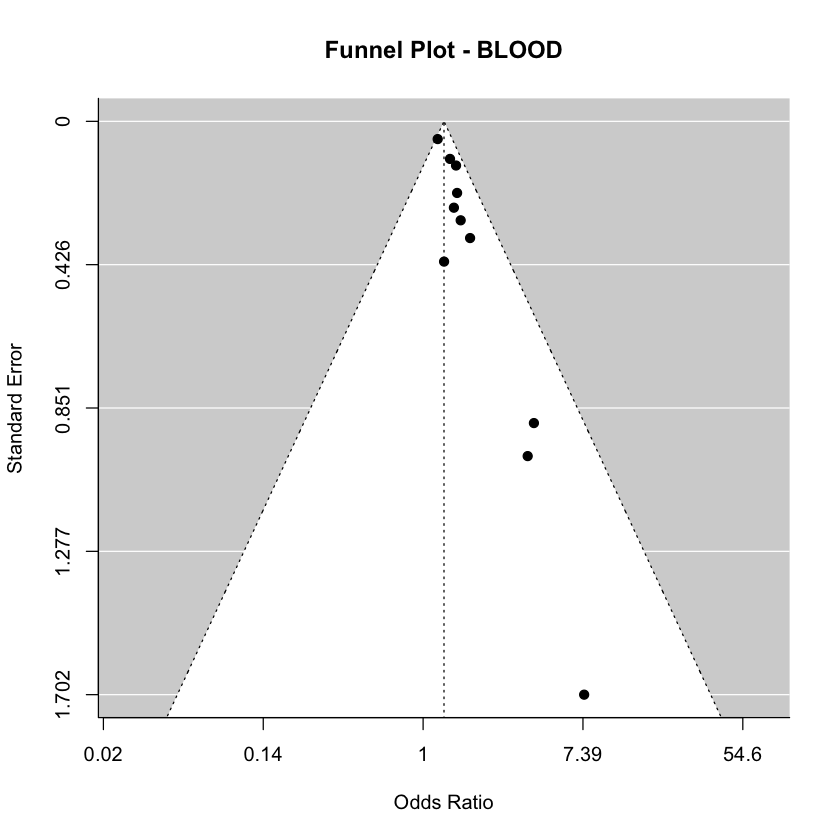

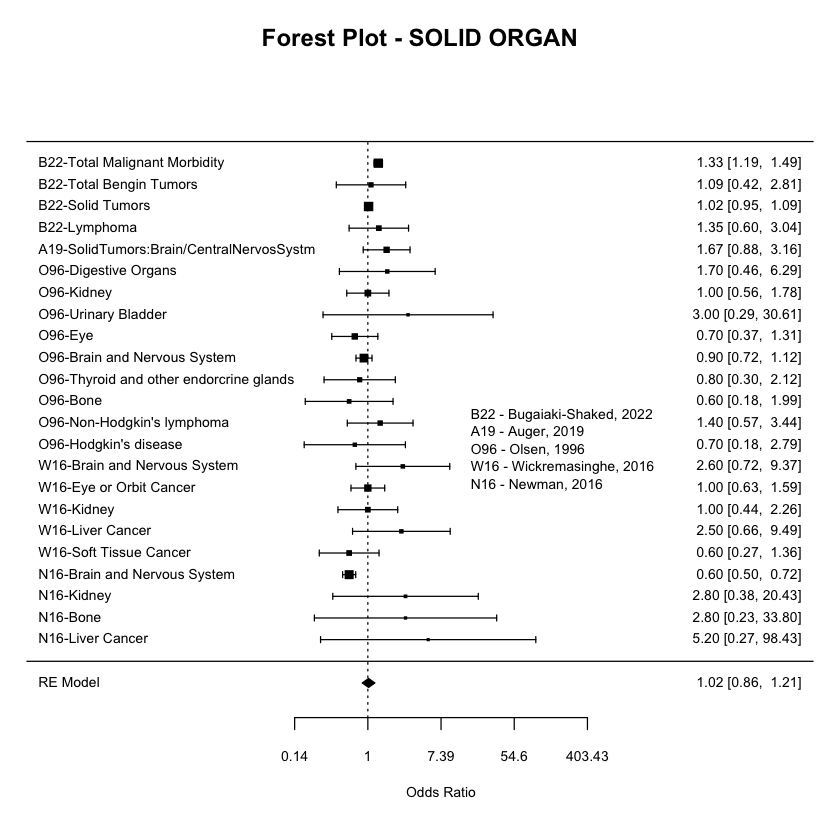

----------------------------------------------------------------
Cancer Group:  
----------------------------------------------------------------
Number of rows: 13 
The overall effect size (odds ratio) is 1.142503 with 95% confidence interval ( 0.7885917 ,  1.655245 )
Pooled odds ratio: 1.811236 
95% CI: 1.646238 - 1.992771 

Random-Effects Model (k = 13; tau^2 estimator: DL)

  logLik  deviance       AIC       BIC      AICc   
-14.7291   48.9196   33.4581   34.5880   34.6581   

tau^2 (estimated amount of total heterogeneity): 0.3791 (SE = 0.2643)
tau (square root of estimated tau^2 value):      0.6157
I^2 (total heterogeneity / total variability):   96.98%
H^2 (total variability / sampling variability):  33.10

Test for Heterogeneity:
Q(df = 12) = 397.1413, p-val < .0001

Model Results:

estimate      se    zval    pval    ci.lb   ci.ub    
  0.1332  0.1891  0.7043  0.4812  -0.2375  0.5039    

---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1



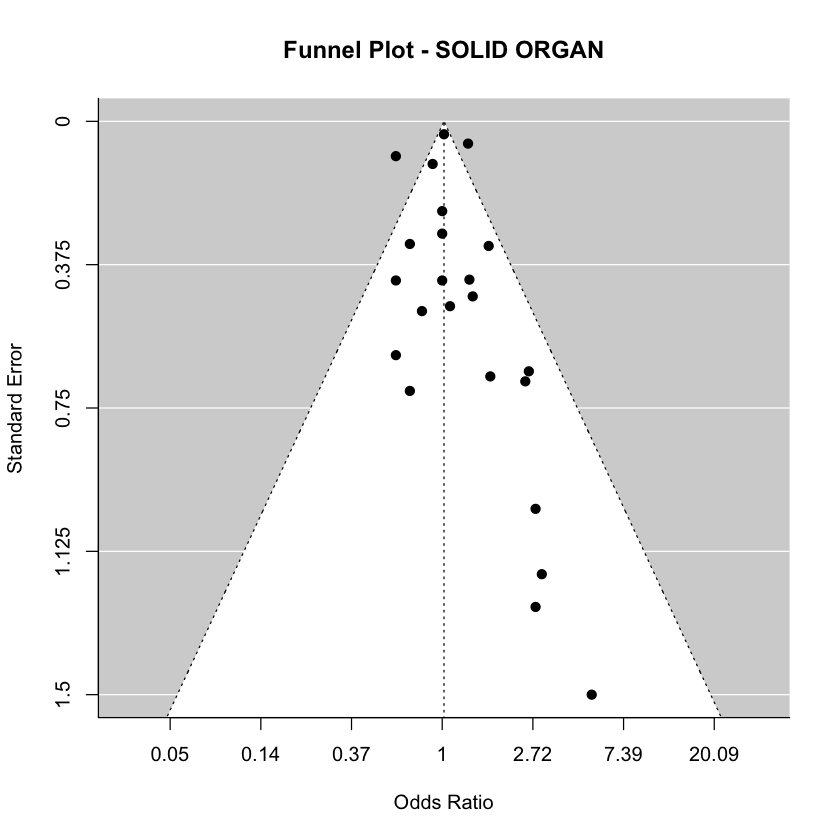

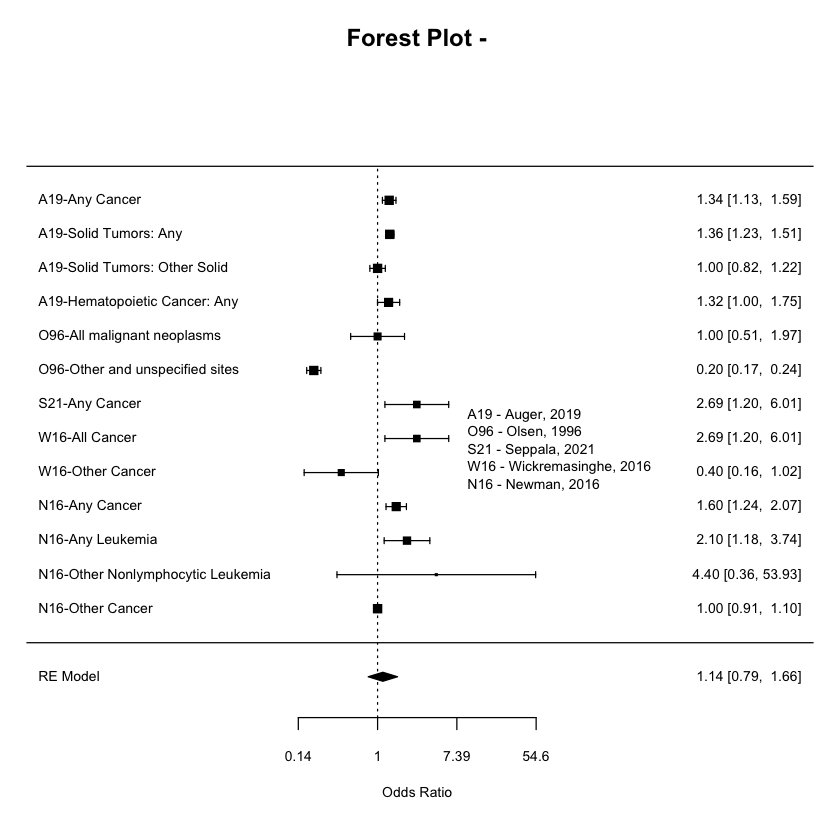

----------------------------------------------------------------


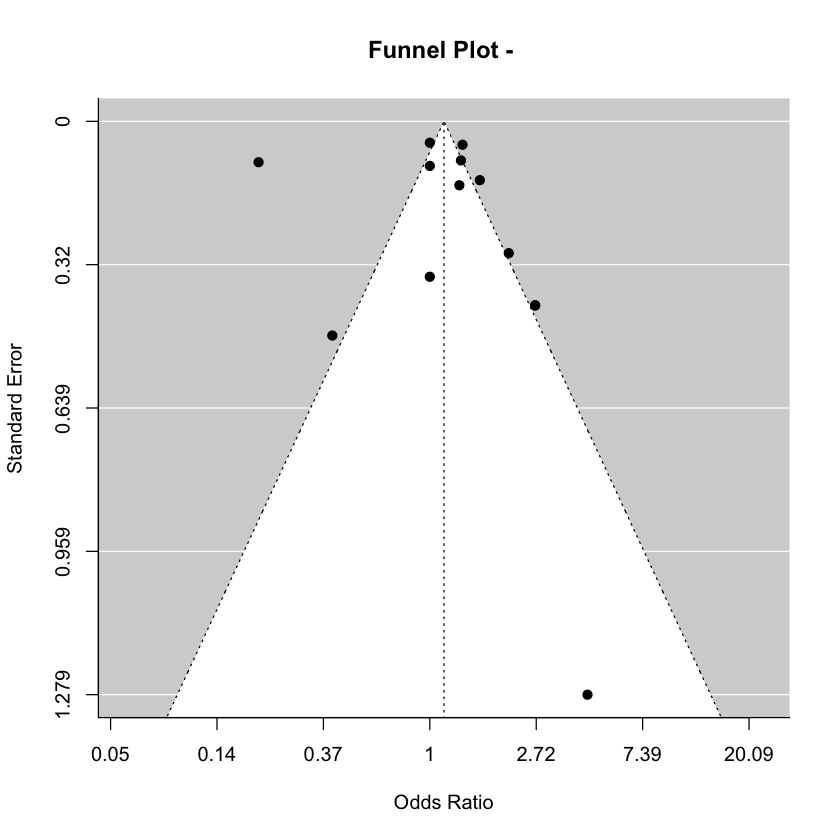

In [24]:
# subset the data by cancer type and draw the forest plot
for (cancer_group_name in unique(data$cancer_group)) {
    cat("Cancer Group:", cancer_group_name, "\n")
    cat("----------------------------------------------------------------\n")
    focus_data <- data[data$cancer_group == cancer_group_name,]
    draw_forest_and_funnel_plots(focus_data, cancer_group_name)
    # print a dotted line to separate the plots
    cat("----------------------------------------------------------------\n")
}
